# LLM Fine Tuning

In [78]:
import pandas as pd

In [80]:
questions = pd.read_csv("questions.csv")

In [81]:
questions.head()
questions.tail()

,answer,question
290,Wrong,The priority value in a MongoDB replica set on...
291,Correct,The $map operator in MongoDB's aggregation fra...
292,Wrong,The $map operator in MongoDB is used to filter...
293,Correct,MongoDB's $accumulator operator allows for cus...
294,Wrong,The $accumulator operator in MongoDB is only u...


### Preprocessing

In [82]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   answer    295 non-null    object
 1   question  295 non-null    object
dtypes: object(2)
memory usage: 4.7+ KB


In [83]:
# Dropping rows where 'question' is missing
questions.dropna(subset=['question'], inplace=True)
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   answer    295 non-null    object
 1   question  295 non-null    object
dtypes: object(2)
memory usage: 4.7+ KB


### Train-Test Split
Select samples for validation and test data

In [84]:
val_test_data = questions.sample(100)  # sample 100 items from the above data
val = val_test_data.head(50) # Take the first 50
test = val_test_data.tail(50) # Take the last 50

train = questions[~questions.index.isin(val_test_data.index)] # Take the remaining ones for training

len(train)
train

,answer,question
1,Correct,MongoDB stores data in flexible JSON-like docu...
3,Wrong,MongoDB requires a predefined schema for all d...
4,Correct,"The default primary key in MongoDB is named ""_..."
6,Wrong,MongoDB uses SQL as its primary query language.
7,Correct,MongoDB supports geospatial indexing and queries.
...,...,...
289,Correct,"In a MongoDB replica set, the priority value a..."
290,Wrong,The priority value in a MongoDB replica set on...
291,Correct,The $map operator in MongoDB's aggregation fra...
292,Wrong,The $map operator in MongoDB is used to filter...


### Fine-tuning data formatting

We can now rearrange the dataset into the necessary format in order to start the fine tuning job.
The format is as follows:

```json
{"messages": [{"role": "system", "content": "You are a helpful assistant for answering questions about MongoDB"}, {"role": "user", "content": "question"}, {"role": "assistant", "content": "Correct or Wrong"}]}
```

In [85]:
system_prompt = "Given the question about MongoDB, just say Correct or Wrong"

In [86]:
sample_prompt = {"messages": [{"role": "system", "content": system_prompt},
                              {"role": "user", "content": train["question"].iloc[0]},
                              {"role": "assistant", "content": train["answer"].iloc[0]}]}


In [87]:
print(sample_prompt)

{'messages': [{'role': 'system', 'content': 'Given the question about MongoDB, just say Correct or Wrong'}, {'role': 'user', 'content': 'MongoDB stores data in flexible JSON-like documents.'}, {'role': 'assistant', 'content': 'Correct'}]}


In [88]:
def df_to_format(df):
    formatted_data = []
    
    for index, row in df.iterrows():
        entry = {"messages": [{"role": "system", "content": system_prompt},
                              {"role": "user", "content": row["question"]},
                              {"role": "assistant", "content": row["answer"]}]}

        formatted_data.append(entry)

    return formatted_data


In [89]:
data = df_to_format(train)

In [90]:
print(data[100])

{'messages': [{'role': 'system', 'content': 'Given the question about MongoDB, just say Correct or Wrong'}, {'role': 'user', 'content': 'MongoDB allows for the creation of compound text indexes on multiple fields.'}, {'role': 'assistant', 'content': 'Correct'}]}


Let's dump this list of dictionaries into the training file

In [91]:
import json
with open('fine_tuning_data.jsonl', 'w') as f:
    for entry in data:
        f.write(json.dumps(entry))
        f.write("\n")


In [92]:
val_data = df_to_format(val)

In [93]:
import json
with open('fine_tuning_data_val.jsonl', 'w') as f:
    for entry in val_data:
        f.write(json.dumps(entry))
        f.write("\n")

## Training

In [94]:
import os
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()

True

In [95]:
client = OpenAI()
file_upload_response = client.files.create(
  file=open("fine_tuning_data.jsonl", "rb"),
  purpose="fine-tune",
)

In [96]:
client.files.retrieve(file_upload_response.id)

FileObject(id='file-0F7bAVNK0c4GgEF7wyyKuKsY', bytes=51524, created_at=1723781068, filename='fine_tuning_data.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [97]:
file_upload_response_val = client.files.create(
  file=open("fine_tuning_data_val.jsonl", "rb"),
  purpose="fine-tune",
)

In [98]:
client.files.retrieve(file_upload_response_val.id)

FileObject(id='file-1K7q24OLbQHiD8TiP6nEzGUJ', bytes=13615, created_at=1723781074, filename='fine_tuning_data_val.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

##### Now it's time to start the training process

In [99]:
fine_tuning_response = client.fine_tuning.jobs.create(
  training_file=file_upload_response.id,
  model="gpt-3.5-turbo",
  hyperparameters={"n_epochs": 1},
  validation_file = file_upload_response_val.id
)

To obtain the log, you can use *FineTuningJob.list_events* to which you pass the job id and a limit if you want 

In [101]:
ft_id = fine_tuning_response.id
ft_id

'ftjob-WvKyavfPbRK7fJUYjzK2RYvP'

### Plot losses
Obtain all event data and plot the training metrics.

In [102]:
train_event = client.fine_tuning.jobs.list_events(fine_tuning_job_id=ft_id, limit=500)

In [103]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
for item in train_event.data:
    train_data = item.data
    if train_data and "train_loss" in train_data and "valid_loss" in train_data:
        
        # As the event list returns the most current event at first, we don't want to append but insert
        train_loss.insert(0, train_data["train_loss"])
        val_loss.insert(0, train_data["valid_loss"])
        train_acc.insert(0, train_data["train_mean_token_accuracy"])
        val_acc.insert(0, train_data["valid_mean_token_accuracy"])


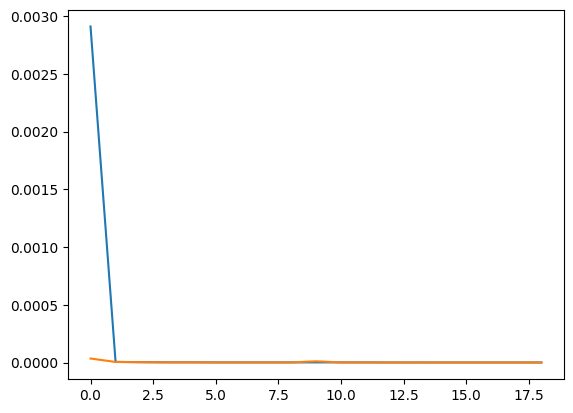

In [104]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_loss)
plt.plot(val_loss)

In [105]:
ft_model_id = client.fine_tuning.jobs.retrieve(ft_id).fine_tuned_model
print(ft_model_id)

ft:gpt-3.5-turbo-0125:personal::9wieB8S8


In [106]:
import numpy as np

### Comparison to gpt-3.5-turbo
Compare how our model works compared to the standard model

In [107]:
import time
# from tqdm.notebook import tqdm

def classify_report_baseline(question):
    try:
        completion = client.chat.completions.create(
            model = "gpt-3.5-turbo",
            messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": question}
                    ],
            temperature=0
        )
    except client.error.APIConnectionError:  # To retry if openai loses the connection
        time.sleep(10)
        completion = client.chat.completions.create(
            model = "gpt-3.5-turbo",
            messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": question}
                    ],
            temperature=0
        )

    return completion


In [108]:
predicted_classes = []
ground_truth_classes = []
for line in test.iterrows():
    report, specialty = line[1]["question"], line[1]["answer"]
    ground_truth_classes.append(specialty.strip())  # in case of any trailing
    prediction = classify_report_baseline(report)
    predicted_classes.append(prediction.choices[0].message.content.strip())

In [109]:
(np.array(predicted_classes) == np.array(ground_truth_classes)).mean()

np.float64(0.84)

### Fine-tuned model

In [110]:
def classify_report(question):
    completion = client.chat.completions.create(
        model = ft_model_id, 
        messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": question}
              ]
    )
    return completion

In [111]:
predicted_classes = []
ground_truth_classes = []
for line in test.iterrows():
    report, specialty = line[1]["question"], line[1]["answer"]
    ground_truth_classes.append(specialty.strip())  # in case of any trailing
    prediction = classify_report(report)
    predicted_classes.append(prediction.choices[0].message.content.strip())

In [112]:
(np.array(predicted_classes) == np.array(ground_truth_classes)).mean()

np.float64(1.0)